# Max-P Regionalization for Multiple Components

**Authors:** **[Sergio Rey](https://github.com/sjsrey)**


The `max-p` problem involves the clustering of a set of geographic areas into the maximum number of homogeneous regions such that the value of a spatially extensive regional attribute is above a predefined threshold value. The spatially extensive attribute can be specified to ensure that each region contains sufficient population size, or a minimum number of enumeration units. The number of regions $p$ is endogenous to the problem and is useful for regionalization problems where the analyst does not require a fixed number of regions a-priori.

Originally formulated as a mixed-integer problem in [Duque, Anselin, Rey (2012)](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1467-9787.2011.00743.x), `max-p` is an [NP-hard problem](https://en.wikipedia.org/wiki/NP-hardness) and exact solutions are only feasible for small problem sizes. As such, a number of heuristic solution approaches have been suggested. PySAL implements the heuristic approach described in
[Wei, Rey, and Knaap (2020)](https://www.tandfonline.com/doi/full/10.1080/13658816.2020.1759806).

One issue with the current version of maxp is when it is applied to a collection of areas that have multiple connected components *and* some of the components do not allow for feasible region building.

In [1]:
%load_ext watermark
%watermark

Last updated: 2022-03-13T20:56:01.385260-07:00

Python implementation: CPython
Python version       : 3.9.10
IPython version      : 8.1.1

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 21.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 10
Architecture: 64bit



In [2]:
from spopt.region import MaxPHeuristic as MaxP
import matplotlib.pyplot as plt

import geopandas
import libpysal
import matplotlib
import numpy
import spopt
import warnings
from scipy.spatial import KDTree

plt.rcParams["figure.figsize"] = [12, 8]
warnings.filterwarnings("ignore")

RANDOM_SEED = 123456

%config InlineBackend.figure_format = "retina"
%watermark -w
%watermark -iv

Watermark: 2.3.0

matplotlib: 3.5.1
spopt     : 0+untagged.558.g614d30e.dirty
geopandas : 0.10.2
numpy     : 1.22.3
libpysal  : 4.6.2



In [3]:
from shapely.geometry import Polygon, box

In [4]:
n_cols = 5
n_rows = 10
b = 0
h = w = 10
component_0 = [box(l*w, b, l*w+w, b+h) for l in range(n_cols)] 
b = b + h*2
component_1 = [box(l*w, b + h * r, l * w + w, b +  h+ h * r) for r in range(n_rows) for l in range(n_cols) ] 
geometries = component_0 + component_1

In [5]:
len(geometries)

55

(<AxesSubplot:>,)

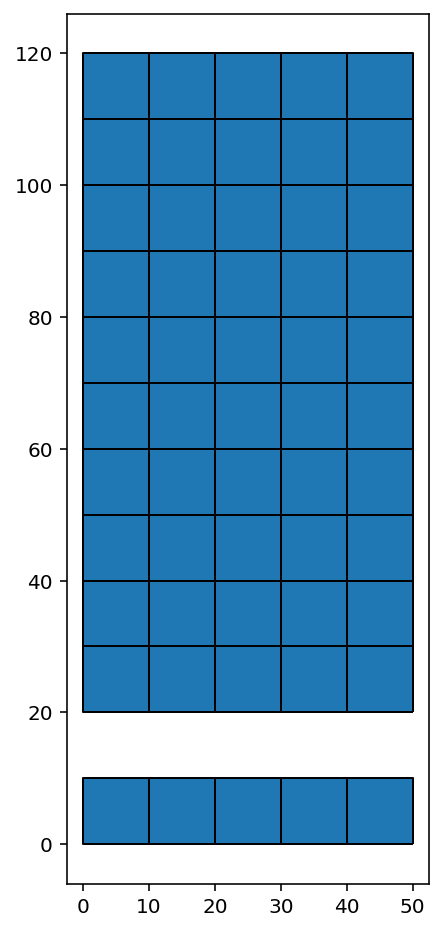

In [6]:
gdf = geopandas.GeoDataFrame(geometry=geometries, 
                             data = numpy.ones((n_cols*n_rows+n_cols,1), int),
                             columns=['var']
                            )
gdf.plot(edgecolor='black'), 

In [7]:
gdf.head()

,var,geometry
0,1,"POLYGON ((10.00000 0.00000, 10.00000 10.00000,..."
1,1,"POLYGON ((20.00000 0.00000, 20.00000 10.00000,..."
2,1,"POLYGON ((30.00000 0.00000, 30.00000 10.00000,..."
3,1,"POLYGON ((40.00000 0.00000, 40.00000 10.00000,..."
4,1,"POLYGON ((50.00000 0.00000, 50.00000 10.00000,..."


In [8]:
w = libpysal.weights.Queen.from_dataframe(gdf)

In [9]:
w.component_labels

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

So we have two components, one with 5 areas in the south and a larger northern component with 50 areas.

In [10]:
import numpy 
numpy.unique(w.component_labels)
rng = numpy.random.default_rng(2021) # set seed for random numbers


We first attempt to solve where the threshold=5. The small southern component is feasible in this case so we should get a solution:

In [11]:
model = MaxP(gdf, w, 'var', 'var', 5, 2, policy='keep')
model.solve()
gdf['region'] = model.labels_
gdf.explore(column='region', categorical=True)

Next we increase the threshold beyond the level of feasibility for this small component:

In [12]:
try:
    model = MaxP(gdf, w, 'var', 'var', 6, 2, policy='keep')
    model.solve() 
except:
    print('No feasible solution!')


No feasible solution!


## Solution: `attach`
We can handle the small component by attaching each area in the infeasible component with its nearest neighbor area belonging to a feasible component. This is done with setting using the `attach` policy.

In [13]:
model = MaxP(gdf, w, 'var', 'var', 6, 2, policy='attach')
model.solve() 
gdf['region'] = model.labels_
gdf.explore(column='region', categorical=True)

## Solution: `drop`

(<AxesSubplot:>,)

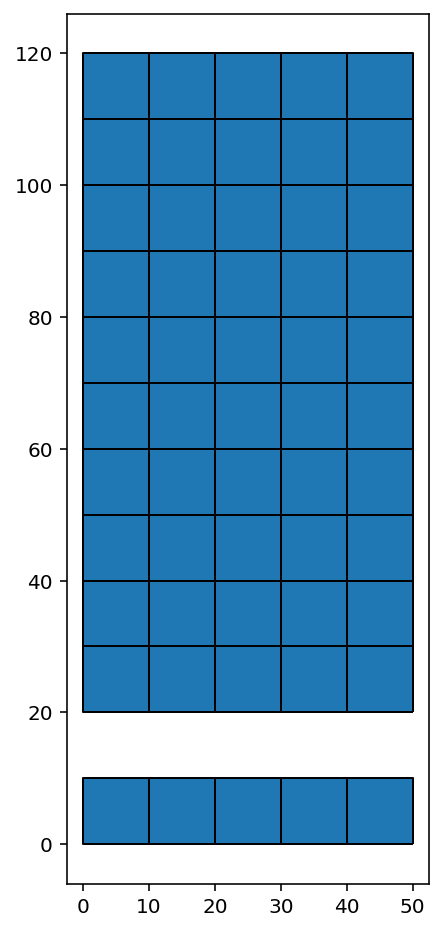

In [17]:
from spopt.region.maxp import infeasible_components
gdf = geopandas.GeoDataFrame(geometry=geometries, 
                             data = numpy.ones((n_cols*n_rows+n_cols,1), int),
                             columns=['var']
                            )
gdf.plot(edgecolor='black'), 

In [20]:
import numpy as np
model = MaxP(gdf, w, 'var', 'var', 6, 2, policy='drop')
model.solve() 
ifcs = infeasible_components(gdf, w, 'var', 6)
keep_ids = np.where(~np.isin(w.component_labels, ifcs))[0]
gdf['region'] = -1
gdf.region.iloc[keep_ids] = model.labels_
gdf.explore(column='region', categorical=True) # areas in region -1 are dropped